In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
import torch
import torch.nn as nn
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
import time




In [ ]:
# https://gymnasium.farama.org/index.html
# !pip install gymnasium
# !pip install torch
# # https://stable-baselines3.readthedocs.io/en/master/guide/install.html
# !pip install stable-baselines3

/opt/anaconda3/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/opt/anaconda3/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
/opt/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/policies.py:486: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 300       |
|    ep_rew_mean     | -1.44e+03 |
| time/              |           |
|    fps             | 2373      |
|    iterations      | 1         |
|    time_elapsed    | 0         |
|    total_timesteps | 1024      |
----------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 300         |
|    ep_rew_mean          | -1.39e+03   |
| time/                   |             |
|    fps                  | 1468        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 2048        |
| train/                  |             |
|    approx_kl            | 0.005060293 |
|    clip_fraction        | 0.0443      |
|    clip_range           | 0.2         |
|    entro

/opt/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Mean reward: -135.79 +/- 5.12


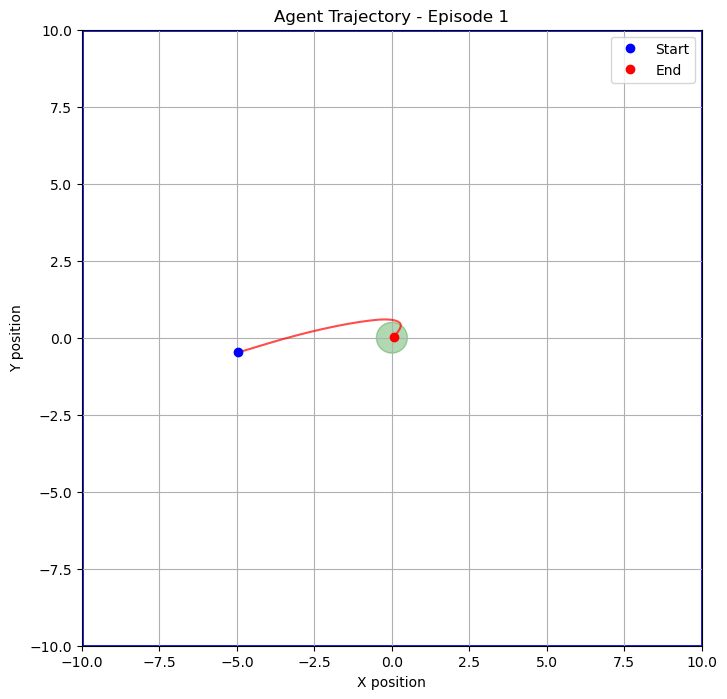

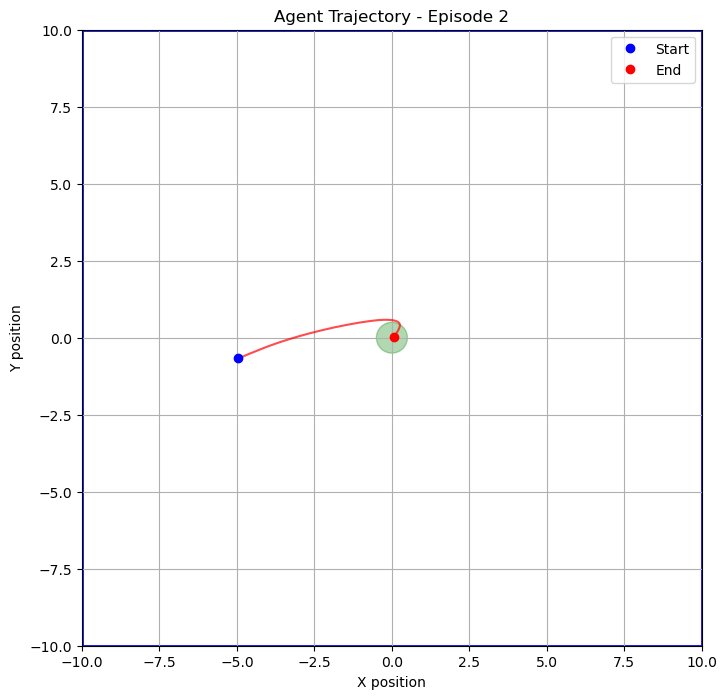

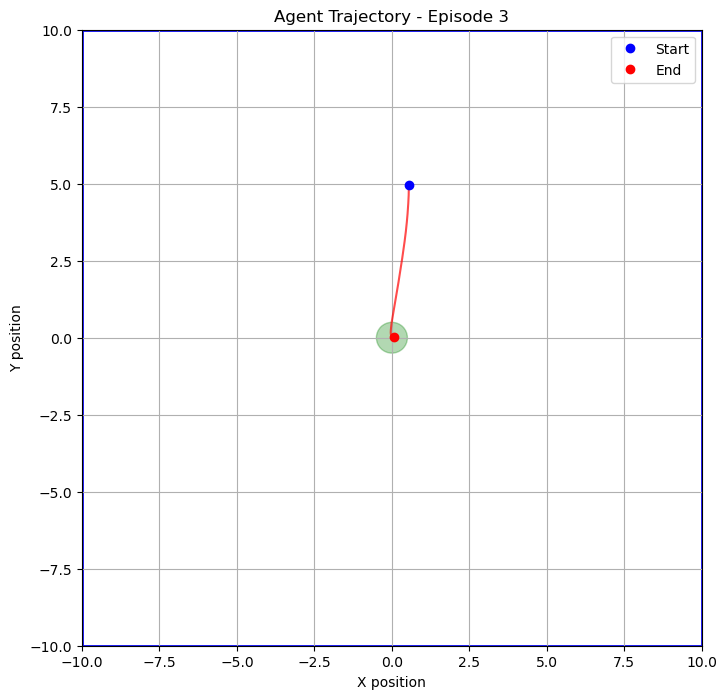

Step 0: Position (-3.66, -3.39), Distance: 4.99, Reward: -4.99
Step 1: Position (-3.64, -3.37), Distance: 4.96, Reward: -4.97
Step 2: Position (-3.62, -3.34), Distance: 4.93, Reward: -4.94
Step 3: Position (-3.59, -3.30), Distance: 4.88, Reward: -4.90
Step 4: Position (-3.55, -3.26), Distance: 4.82, Reward: -4.86
Step 5: Position (-3.50, -3.20), Distance: 4.75, Reward: -4.80
Step 6: Position (-3.45, -3.13), Distance: 4.66, Reward: -4.73
Step 7: Position (-3.39, -3.06), Distance: 4.57, Reward: -4.66
Step 8: Position (-3.32, -2.98), Distance: 4.46, Reward: -4.57
Step 9: Position (-3.25, -2.89), Distance: 4.35, Reward: -4.48
Step 10: Position (-3.17, -2.79), Distance: 4.22, Reward: -4.38
Step 11: Position (-3.08, -2.68), Distance: 4.08, Reward: -4.27
Step 12: Position (-2.99, -2.56), Distance: 3.94, Reward: -4.16
Step 13: Position (-2.89, -2.44), Distance: 3.78, Reward: -4.03
Step 14: Position (-2.78, -2.31), Distance: 3.62, Reward: -3.90
Step 15: Position (-2.66, -2.17), Distance: 3.44, 

In [12]:


class WaterTankEnv(gym.Env):
    """
    A 2D water tank environment where the agent needs to learn to stay in the center.
    
    State space: [x_position, y_position, x_velocity, y_velocity]
    Action space: [thrust_x, thrust_y] - Continuous values between -1 and 1
    """
    
    def __init__(self, tank_size=10.0, max_steps=200, noise_level=0.05):
        super(WaterTankEnv, self).__init__()
        
        # Environment parameters
        self.tank_size = tank_size
        self.max_steps = max_steps
        self.noise_level = noise_level
        
        # Agent dynamics parameters
        self.mass = 1.0
        self.water_resistance = 0.2
        self.max_force = 1.0
        self.dt = 0.1  # time step
        
        # Define action and observation spaces
        self.action_space = spaces.Box(
            low=-1.0, high=1.0, shape=(2,), dtype=np.float32
        )
        self.observation_space = spaces.Box(
            low=np.array([-self.tank_size, -self.tank_size, -5.0, -5.0]),
            high=np.array([self.tank_size, self.tank_size, 5.0, 5.0]),
            dtype=np.float32
        )
        
        # Initialize state
        self.state = None
        self.steps = 0
        self.reset()
        
    def reset(self, seed=None, options=None):
        """Reset the environment to a random position"""
        super().reset(seed=seed)
        
        # Random initial position away from the center
        distance = 0.5 * self.tank_size
        angle = self.np_random.uniform(0, 2 * np.pi)
        x = distance * np.cos(angle)
        y = distance * np.sin(angle)
        
        # Initialize with zero velocity
        self.state = np.array([x, y, 0.0, 0.0], dtype=np.float32)
        self.steps = 0
        
        return self.state, {}
    
    def step(self, action):
        """Take a step in the environment based on the action"""
        self.steps += 1
        
        # Unpack state
        x, y, vx, vy = self.state
        
        # Apply thrust action (with noise to simulate water currents)
        thrust_x = np.clip(action[0], -1.0, 1.0) * self.max_force
        thrust_y = np.clip(action[1], -1.0, 1.0) * self.max_force
        
        # Add environmental noise (water currents)
        thrust_x += self.np_random.uniform(-self.noise_level, self.noise_level)
        thrust_y += self.np_random.uniform(-self.noise_level, self.noise_level)
        
        # Calculate acceleration (F = ma)
        ax = thrust_x / self.mass - self.water_resistance * vx / self.mass
        ay = thrust_y / self.mass - self.water_resistance * vy / self.mass
        
        # Update velocity
        vx += ax * self.dt
        vy += ay * self.dt
        
        # Update position
        x += vx * self.dt
        y += vy * self.dt
        
        # Boundary handling - bounce off walls
        if abs(x) > self.tank_size:
            x = np.sign(x) * self.tank_size
            vx = -vx * 0.9  # Lose some energy on collision
            
        if abs(y) > self.tank_size:
            y = np.sign(y) * self.tank_size
            vy = -vy * 0.9  # Lose some energy on collision
        
        # Update state
        self.state = np.array([x, y, vx, vy], dtype=np.float32)
        
        # Calculate reward
        # Main component: negative distance from center (higher when closer to center)
        distance_from_center = np.sqrt(x**2 + y**2)
        position_reward = -distance_from_center
        
        # Secondary component: penalize high velocities (to encourage stability)
        velocity_penalty = -0.1 * (vx**2 + vy**2)
        
        # Combine rewards
        reward = position_reward + velocity_penalty
        
        # Check if episode is done
        done = self.steps >= self.max_steps
        
        # Additional info
        info = {
            "distance_from_center": distance_from_center,
            "position": (x, y),
            "velocity": (vx, vy)
        }
        
        return self.state, reward, done, False, info
    
    def render(self):
        """Simple text-based rendering"""
        x, y, vx, vy = self.state
        distance = np.sqrt(x**2 + y**2)
        print(f"Position: ({x:.2f}, {y:.2f}), Distance from center: {distance:.2f}")


def visualize_agent(env, model, num_episodes=3):
    """Visualize agent behavior"""
    for episode in range(num_episodes):
        # Initialize plotting
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xlim(-env.tank_size, env.tank_size)
        ax.set_ylim(-env.tank_size, env.tank_size)
        ax.set_xlabel('X position')
        ax.set_ylabel('Y position')
        ax.set_title(f'Agent Trajectory - Episode {episode+1}')
        
        # Draw tank boundary
        tank = plt.Rectangle((-env.tank_size, -env.tank_size), 
                           2*env.tank_size, 2*env.tank_size, 
                           linewidth=2, edgecolor='blue', facecolor='none')
        ax.add_patch(tank)
        
        # Draw center target
        center = plt.Circle((0, 0), 0.5, color='green', alpha=0.3)
        ax.add_patch(center)
        
        # Run episode
        obs, _ = env.reset()
        done = False
        trajectory_x = [obs[0]]
        trajectory_y = [obs[1]]
        
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _, info = env.step(action)
            trajectory_x.append(obs[0])
            trajectory_y.append(obs[1])
        
        # Plot trajectory
        ax.plot(trajectory_x, trajectory_y, 'r-', alpha=0.7)
        ax.plot(trajectory_x[0], trajectory_y[0], 'bo', label='Start')
        ax.plot(trajectory_x[-1], trajectory_y[-1], 'ro', label='End')
        ax.legend()
        
        plt.grid(True)
        plt.show()


# Create and validate environment
env = WaterTankEnv(tank_size=10.0, max_steps=300, noise_level=0.1)
check_env(env)

# Train the agent
model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=0.0003,
    gamma=0.99,  # discount factor
    n_steps=1024,
    batch_size=64,
    n_epochs=10,
    policy_kwargs=dict(
        net_arch=[dict(pi=[64, 64], vf=[64, 64])],
        activation_fn=nn.Tanh
    )
)

# Train
train_timesteps = 100000
model.learn(total_timesteps=train_timesteps)

# Evaluate the trained agent
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Visualize agent behavior
visualize_agent(env, model)

# Test the agent interactively
obs, _ = env.reset()
cumulative_reward = 0
for step in range(1000):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, info = env.step(action)
    cumulative_reward += reward
    
    # Print current state
    x, y, vx, vy = obs
    distance = np.sqrt(x**2 + y**2)
    print(f"Step {step}: Position ({x:.2f}, {y:.2f}), Distance: {distance:.2f}, Reward: {reward:.2f}")
    
    if done:
        print(f"Episode finished after {step+1} steps. Total reward: {cumulative_reward:.2f}")
        break
    
    time.sleep(0.01)  # Slow down visualization